Baseline Model Performance: R² = 0.3530, RMSE = 0.015720


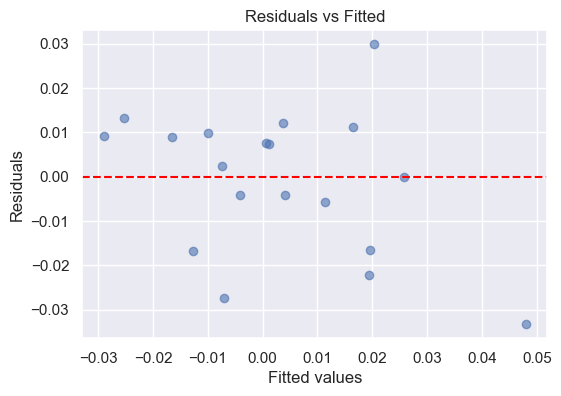

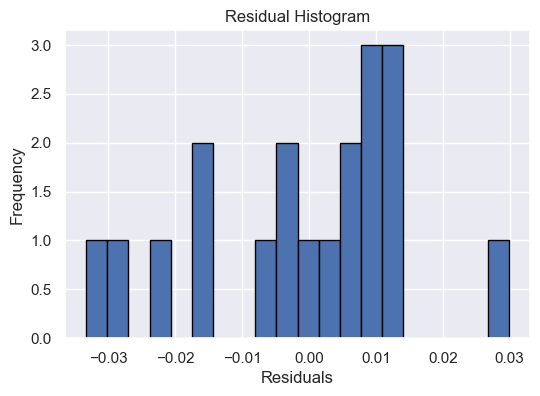

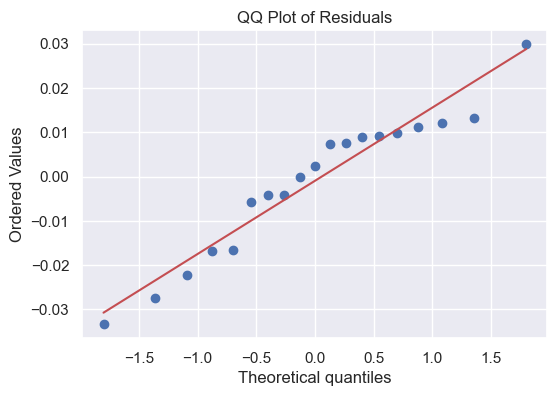


Model Coefficients:
         Feature  Coefficient
0    Return_Lag1    -0.281969
1    Return_Lag2    -0.355639
2    Return_Lag5    -0.105737
3           MA_5    -0.004518
4          MA_10    -0.004588
5          MA_20     0.009290
6   Volatility_5    -0.009873
7  Volatility_20     0.743241
8         RSI_14     0.003078


In [5]:
import sys
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split


sns.set_theme()
np.random.seed(7)


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


from src.features import make_features


data_path = Path("../data/processed/seagate_no_outliers.csv")
df = pd.read_csv(data_path)


df = make_features(df, price_col="price", date_col="date")


df = df.dropna().reset_index(drop=True)

feature_cols = [
    "Return_Lag1", "Return_Lag2", "Return_Lag5",
    "MA_5", "MA_10", "MA_20",
    "Volatility_5", "Volatility_20",
    "RSI_14"
]


missing = [c for c in feature_cols if c not in df.columns]
if missing:
    raise RuntimeError(f"Missing expected features in dataframe: {missing}")

X = df[feature_cols]
y = df["Return"]  


split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)


mse = mean_squared_error(y_test, y_pred)   
rmse = np.sqrt(mse)                        
r2 = r2_score(y_test, y_pred)

print(f"Baseline Model Performance: R² = {r2:.4f}, RMSE = {rmse:.6f}")


resid = y_test - y_pred
fitted = y_pred


plt.figure(figsize=(6,4))
plt.scatter(fitted, resid, alpha=0.6)
plt.axhline(0, ls='--', color='red')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()


plt.figure(figsize=(6,4))
plt.hist(resid, bins=20, edgecolor='black')
plt.title('Residual Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(6,4))
st.probplot(resid, dist='norm', plot=plt)
plt.title('QQ Plot of Residuals')
plt.show()


coef_df = pd.DataFrame({
    "Feature": feature_cols,
    "Coefficient": lr.coef_
})
print("\nModel Coefficients:")
print(coef_df)

